Paso 1: Simulación de Datos (Open Data Style)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler

# 1. Generación de Datos Sintéticos (Simulando 1,000 solicitantes)
np.random.seed(42) # Para reproducibilidad
n_samples = 1000

# Variables simuladas
# Ingreso mensual entre 5k y 50k
ingresos = np.random.normal(20000, 10000, n_samples) 
ingresos = np.clip(ingresos, 5000, 80000)

# Deuda total actual
deuda = np.random.normal(50000, 30000, n_samples)
deuda = np.clip(deuda, 0, 150000)

# Score de Buró (simulado 300 a 850)
buro_score = np.random.randint(300, 850, n_samples)

# Antigüedad en el empleo (años)
antiguedad = np.random.randint(0, 20, n_samples)

# Variable Objetivo (Target): 0 = Paga (Buen cliente), 1 = Default (No paga)
# Creamos una lógica: si tiene poca deuda, alto ingreso y buen buró, es menos probable que falle.
probabilidad_default = (
    (deuda / (ingresos + 1)) * 3 +  # Alta relación deuda/ingreso aumenta riesgo
    (850 - buro_score) / 100 -      # Bajo score aumenta riesgo
    antiguedad * 0.5                # Mayor antigüedad reduce riesgo
)

# Normalizamos probabilidad a 0-1 (función sigmoide simple para simulación)
import scipy.special
prob_real = scipy.special.expit(probabilidad_default - 2) # Ajuste base
default = (np.random.rand(n_samples) < prob_real).astype(int)

# Crear DataFrame
df = pd.DataFrame({
    'Ingreso_Mensual': ingresos,
    'Deuda_Total': deuda,
    'Score_Buro': buro_score,
    'Antiguedad_Empleo': antiguedad,
    'Default': default # Esta es la variable que queremos predecir
})

print("✅ Datos generados exitosamente.")
print(df.head())

✅ Datos generados exitosamente.
   Ingreso_Mensual   Deuda_Total  Score_Buro  Antiguedad_Empleo  Default
0     24967.141530  91980.663098         713                 12        1
1     18617.356988  77739.010487         657                  1        1
2     26476.885381  51788.911098         374                  4        1
3     35230.298564  30591.896669         654                 16        0
4     17658.466253  70946.699408         487                  5        1


Paso 2: Preprocesamiento y División
En el mundo cuantitativo, los modelos necesitan datos limpios y escalados.

In [7]:
# 2. Separar las características (X) del objetivo (y)
X = df[['Ingreso_Mensual', 'Deuda_Total', 'Score_Buro', 'Antiguedad_Empleo']]
y = df['Default']

# Dividir en datos de Entrenamiento (80%) y Prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos (Estandarización)
# Esto es vital en modelos cuantitativos para que el 'Ingreso' (miles) no opaque a la 'Antiguedad' (unidades)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Datos procesados y divididos.")
print(f"Set de entrenamiento: {X_train.shape[0]} usuarios")
print(f"Set de prueba: {X_test.shape[0]} usuarios")


✅ Datos procesados y divididos.
Set de entrenamiento: 800 usuarios
Set de prueba: 200 usuarios


Paso 3: Entrenamiento del Modelo (El Algoritmo)
Utilizaremos una Regresión Logística. Es el modelo base en la industria financiera por ser altamente interpretable (puedes explicarle al regulador por qué rechazaste un crédito).

In [8]:
# 3. Crear y entrenar el modelo
modelo = LogisticRegression()
modelo.fit(X_train_scaled, y_train)

# Hacer predicciones en el set de prueba
y_pred = modelo.predict(X_test_scaled)
y_prob = modelo.predict_proba(X_test_scaled)[:, 1] # Probabilidad de default

print("\n🤖 Modelo entrenado.")
print("Coeficientes (Pesos de cada variable):")
for col, coef in zip(X.columns, modelo.coef_[0]):
    print(f" - {col}: {coef:.4f}")


🤖 Modelo entrenado.
Coeficientes (Pesos de cada variable):
 - Ingreso_Mensual: -2.0286
 - Deuda_Total: 3.0222
 - Score_Buro: -1.4153
 - Antiguedad_Empleo: -2.3967


Paso 4: Evaluación y Visualización 📈
¿Qué tan bueno es nuestro modelo Fintech?


📊 Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.85      0.70      0.77        64
           1       0.87      0.94      0.90       136

    accuracy                           0.86       200
   macro avg       0.86      0.82      0.84       200
weighted avg       0.86      0.86      0.86       200



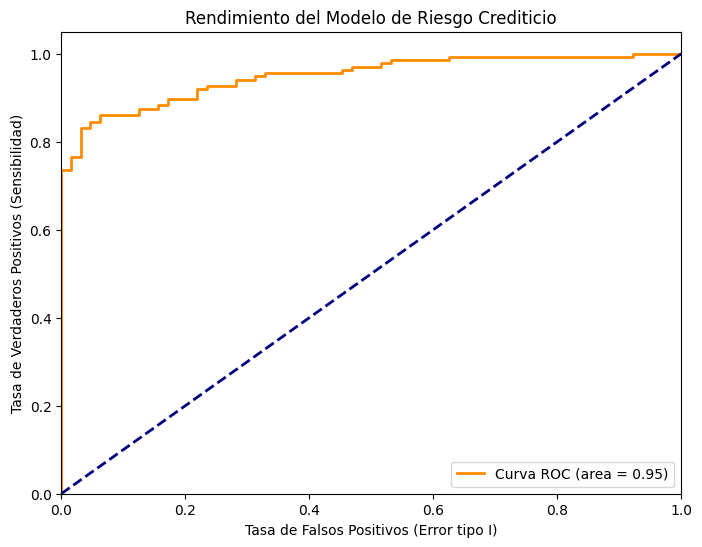

In [9]:
# 4. Evaluación
print("\n📊 Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Visualizar la Curva ROC (Capacidad de distinción del modelo)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (Error tipo I)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Rendimiento del Modelo de Riesgo Crediticio')
plt.legend(loc="lower right")
plt.show()

Paso 5: Simulación de una Decisión Real 🚀
Vamos a probar el modelo con dos clientes nuevos hipotéticos.

In [10]:
# 5. Casos de Uso
# Cliente A: Altos ingresos, poca deuda, buen buró
cliente_A = np.array([[50000, 10000, 750, 5]]) 

# Cliente B: Bajos ingresos, mucha deuda, mal buró
cliente_B = np.array([[8000, 100000, 450, 1]]) 

# Escalar datos de los nuevos clientes
# Convertimos a DataFrame para mantener los nombres de las columnas y evitar el Warning
clientes_nuevos = pd.DataFrame(np.vstack([cliente_A, cliente_B]), 
                             columns=['Ingreso_Mensual', 'Deuda_Total', 'Score_Buro', 'Antiguedad_Empleo'])
clientes_scaled = scaler.transform(clientes_nuevos)

# Predecir
predicciones = modelo.predict_proba(clientes_scaled)[:, 1]

print("\n🔮 Resultados del Motor de Decisiones:")
print(f"Cliente A (Perfil Bajo Riesgo) - Probabilidad de Default: {predicciones[0]*100:.2f}%")
print(f"Cliente B (Perfil Alto Riesgo) - Probabilidad de Default: {predicciones[1]*100:.2f}%")

# Regla de negocio Fintech
umbral_riesgo = 0.50
for i, prob in enumerate(predicciones):
    decision = "APROBADO ✅" if prob < umbral_riesgo else "RECHAZADO ❌"
    print(f"Decisión para Cliente {chr(65+i)}: {decision}")


🔮 Resultados del Motor de Decisiones:
Cliente A (Perfil Bajo Riesgo) - Probabilidad de Default: 0.08%
Cliente B (Perfil Alto Riesgo) - Probabilidad de Default: 100.00%
Decisión para Cliente A: APROBADO ✅
Decisión para Cliente B: RECHAZADO ❌
